# LIBRARIES

In [1]:
import math
import keras
from keras import backend as K
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications import MobileNetV2
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# TRAINING AND TESTING DATA

# size of batch( considering entire dataset is a tedious task and hence we consider a batch which is group of images)

# preprocessing function is used for preprocessing of images which means mapping the pixels in the image between the values of 0 and 1

# image data generator is used to augment images when model is still in training phase which means adding transformations to images and genrating variety of images  and here we are importing the orginal set of images from directory.

In [2]:
batch_size = 32 
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
training_set = train_gen.flow_from_directory(
    directory="../dataset/training_set",
    target_size=(224,224), # size of image
    batch_size=batch_size,
    class_mode='categorical', #used for multi class problems
    shuffle=True # shuffles images in dataset so that model dont get overtrained
) 
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_gen.flow_from_directory(
    directory="../dataset/test_set",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 9000 images belonging to 45 classes.
Found 4500 images belonging to 45 classes.


# MOBILENETV2 MODEL

# input shape- input image resolution
# include_top- specifies whether to include the fully-connected layer at the top of the network
# weights- path of the weights file that used, here imagenet which is pretrained

# dense
# 45-units-output shape-45 classes here
# activation - softmax - predict classes based on the highest probability among all the classes.
# kernel_regularizer- penality applied on layer kernel and these penalties are added into loss function- l2=0.001 - here penality means reducing the weights of insignificant parameters

In [3]:
#imports the mobilenet model and discards the last fully connected neuron layer.
mobilenetmodel = MobileNetV2(weights='imagenet', input_shape= (224, 224, 3), include_top=False)

#print the summary about model which gives description on model parameters.
print(mobilenetmodel.summary())

#storing output of mobilenet model to x
x = mobilenetmodel.output 

#globalAveragePooling2d() function is used for applying global average pooling operation on x
x = GlobalAveragePooling2D()(x) 

# adding final layer with softmax activation
preds = Dense(45, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x) 

# final model with input of mobilenet model and output known as preds
model_final = Model(inputs = mobilenetmodel.input, outputs = preds) 

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

# COMPILATION

# optimizer - used to change attributes of model and improve accuracy

# SGD-stochastic gradient descent - instead of considering whole dataset as a batch sgd considers batch of size 1 per each iteration to achieve minima - lesser computation

# metrics- model compiled to determine accuracy

# categorical_crossentropy - loss function used for multi class problems - labelling used - one hot encoding

# compile() - used to define loss function,optimizer,metrics etc. Compiling a model is required to finalise the model and make it completely ready to use. 

In [4]:
training_size = 9000  #training dataset size
validation_size = 4500 #testing dataset size

#number of steps means number of batches for one epoch
steps_per_epoch = math.ceil(training_size / batch_size)
print(steps_per_epoch)

validation_steps = math.ceil(validation_size / batch_size)
print(validation_steps)

# compilation 
optimizer1 = SGD(learning_rate=0.001) 
model_final.compile(optimizer = optimizer1, loss='categorical_crossentropy',metrics=['accuracy'])

#model_final.layers is a array containing layers and total layer count is length of the array
print("total layer count", len(model_final.layers)) 

282
141
total layer count 156


# MODEL SUMMARY

In [5]:
print(model_final.summary()) # model summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

# FIT THE MODEL

# Shuffles help to feed different data into the model during training, It helps with the accuracy of the model by getting different batches of input before each epoch.

# Callback is an object that can perfom actions at various stages of training and it can be passed to fit().

# Workers used for faster data processing - number of threads(multi processing) generating batches in parallel. Batches are computed in parallel on the CPU.

# HDF5(Hierarchical Data Format) is a general purpose library and file format for storing large,complex,hetrogenous, scientific data (ex:datasets) 

In [6]:
earlystop1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

#fit() is for training the model with the given inputs (and corresponding training labels).
hist1 = model_final.fit(
    training_set,
    steps_per_epoch=steps_per_epoch,
    epochs=2, #2 complete cycles through entire dataset
    validation_data = test_set,
    validation_steps=validation_steps,
    callbacks=[earlystop1],
    workers=10,
    shuffle=True 
) 

model_final.save("currency_mobilenetmodel.h5") #saving final model as hdf file

# currency class labels and their encoding
print("mobilenet_currency_class_indices", training_set.class_indices) 

#opening a text file
f = open("mobilenet_currency_class_indices.txt", "w")

# writing this class labels into a text file
f.write(str(training_set.class_indices))

f.close()#closing a file

Epoch 1/2
282/282 [==============================] - 782s 3s/step - loss: 2.6976 - accuracy: 0.4578 - val_loss: 2.7901 - val_accuracy: 0.3193
Epoch 2/2
282/282 [==============================] - 771s 3s/step - loss: 0.9607 - accuracy: 0.9177 - val_loss: 1.5051 - val_accuracy: 0.7904
mobilenet_currency_class_indices {'100_new_back_down': 0, '100_new_back_up': 1, '100_new_front_down': 2, '100_new_front_up': 3, '100_old_back_down': 4, '100_old_back_up': 5, '100_old_front_down': 6, '100_old_front_up': 7, '10_new_back_down': 8, '10_new_back_up': 9, '10_new_front_down': 10, '10_new_front_up': 11, '10_old_back_down': 12, '10_old_back_up': 13, '10_old_front_down': 14, '10_old_front_up': 15, '2000_new_back_down': 16, '2000_new_back_up': 17, '2000_new_front_down': 18, '2000_new_front_up': 19, '200_new_back_down': 20, '200_new_back_up': 21, '200_new_front_down': 22, '200_new_front_up': 23, '20_new_back_down': 24, '20_new_back_up': 25, '20_new_front_down': 26, '20_new_front_up': 27, '20_old_back_d

# PLOTTING

# history callback - records training metrics for each epoch and can use data stored in history object to create plots

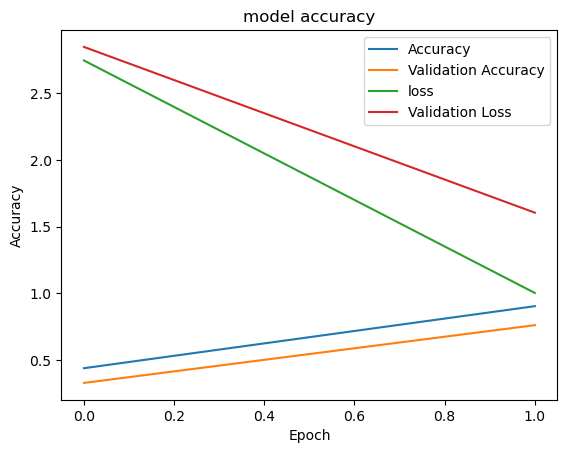

In [7]:
plt.plot(hist1.history["accuracy"])#accuracy
plt.plot(hist1.history['val_accuracy'])#validation accuracy
plt.plot(hist1.history['loss'])#loss
plt.plot(hist1.history['val_loss'])#validation loss
plt.title("model accuracy") #title of graph
plt.ylabel("Accuracy") #ylabel
plt.xlabel("Epoch") #xlabel
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"]) #legend
plt.savefig('mobilenet' + '_plot.png') #saving plot
plt.show() #displaying plot

# COMPLETE CODE

Found 9000 images belonging to 45 classes.
Found 4500 images belonging to 45 classes.
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']            

                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
          

 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_d

 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
          

                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
          

                                                                                                  
 expanded_conv_depthwise (Depth  (None, 112, 112, 32  288        ['Conv1_relu[0][0]']             
 wiseConv2D)                    )                                                                 
                                                                                                  
 expanded_conv_depthwise_BN (Ba  (None, 112, 112, 32  128        ['expanded_conv_depthwise[0][0]']
 tchNormalization)              )                                                                 
                                                                                                  
 expanded_conv_depthwise_relu (  (None, 112, 112, 32  0          ['expanded_conv_depthwise_BN[0][0
 ReLU)                          )                                ]']                              
                                                                                                  
 expanded_

 block_3_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_3_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_4_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_3_project_BN[0][0]']     
                                                                                                  
 block_4_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_4_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_4_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_4_expand_BN[0][0]']      
                                                                                                  
 block_4_d

                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_7_depthwise_BN[0][0]']   
                                                                                                  
 block_7_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_7_depthwise_relu[0][0]'] 
                                                                                                  
 block_7_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_7_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_add (Add)              (None, 14, 14, 64)   0           ['block_6_project_BN[0][0]',     
                                                                  'block_7_project_BN[0][0]']     
          

C:\Users\Charan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 block_8_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_8_expand_BN[0][0]']      
                                                                                                  
 block_8_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_8_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_8_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_8_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_8_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_8_depthwise_BN[0][0]']   
          

                                                                  'block_11_project_BN[0][0]']    
                                                                                                  
 block_12_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_11_add[0][0]']           
                                                                                                  
 block_12_expand_BN (BatchNorma  (None, 14, 14, 576)  2304       ['block_12_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_12_expand_relu (ReLU)    (None, 14, 14, 576)  0           ['block_12_expand_BN[0][0]']     
                                                                                                  
 block_12_depthwise (DepthwiseC  (None, 14, 14, 576)  5184       ['block_12_expand_relu[0][0]']   
 onv2D)   

 block_15_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_15_depthwise_BN[0][0]']  
                                                                                                  
 block_15_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_15_depthwise_relu[0][0]']
                                                                                                  
 block_15_project_BN (BatchNorm  (None, 7, 7, 160)   640         ['block_15_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_15_add (Add)             (None, 7, 7, 160)    0           ['block_14_add[0][0]',           
                                                                  'block_15_project_BN[0][0]']    
                                                                                                  
 block_16_

C:\Users\Charan\AppData\Local\Temp\ipykernel_18416\3166901465.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist1 = model_final.fit_generator(


Epoch 1/2
282/282 [==============================] - 749s 3s/step - loss: 2.7143 - accuracy: 0.4557 - val_loss: 2.8179 - val_accuracy: 0.3642
Epoch 2/2
282/282 [==============================] - 751s 3s/step - loss: 0.9925 - accuracy: 0.9091 - val_loss: 1.5986 - val_accuracy: 0.7631
mobilenet_currency_class_indices {'100_new_back_down': 0, '100_new_back_up': 1, '100_new_front_down': 2, '100_new_front_up': 3, '100_old_back_down': 4, '100_old_back_up': 5, '100_old_front_down': 6, '100_old_front_up': 7, '10_new_back_down': 8, '10_new_back_up': 9, '10_new_front_down': 10, '10_new_front_up': 11, '10_old_back_down': 12, '10_old_back_up': 13, '10_old_front_down': 14, '10_old_front_up': 15, '2000_new_back_down': 16, '2000_new_back_up': 17, '2000_new_front_down': 18, '2000_new_front_up': 19, '200_new_back_down': 20, '200_new_back_up': 21, '200_new_front_down': 22, '200_new_front_up': 23, '20_new_back_down': 24, '20_new_back_up': 25, '20_new_front_down': 26, '20_new_front_up': 27, '20_old_back_d

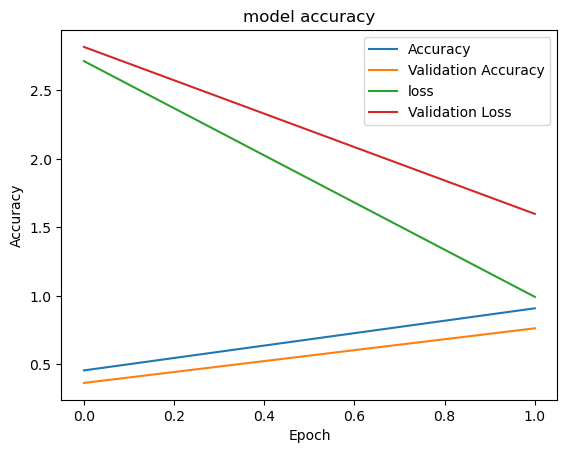

In [1]:
import math
import keras
from keras import backend as K
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications import MobileNetV2
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
training_set = train_gen.flow_from_directory(
    directory="../dataset/training_set",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_gen.flow_from_directory(
    directory="../dataset/test_set",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

#imports the mobilenet model and discards the last fully connected neuron layer.
mobilenetmodel = MobileNetV2(weights='imagenet', input_shape= (224, 224, 3), include_top=False)
print(mobilenetmodel.summary())

x = mobilenetmodel.output
x = GlobalAveragePooling2D()(x)
preds = Dense(45, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x) # final layer with softmax activation

model_final = Model(inputs = mobilenetmodel.input, outputs = preds)

training_size = 9000 # 8800
validation_size = 4500 # 4400
steps_per_epoch = math.ceil(training_size / batch_size)
validation_steps = math.ceil(validation_size / batch_size)

# compilation 1
optimizer1 = SGD(lr=0.001)
model_final.compile(optimizer = optimizer1, loss='categorical_crossentropy',metrics=['accuracy'])
print("total layer count", len(model_final.layers))

print(model_final.summary())
earlystop1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
hist1 = model_final.fit_generator(
    training_set,
    steps_per_epoch=steps_per_epoch,
    #epochs=20,
    epochs=2,
    validation_data = test_set,
    validation_steps=validation_steps,
    callbacks=[earlystop1],
    workers=10,
    shuffle=True
)

model_final.save("currency_mobilenetmodel.h5")

print("mobilenet_currency_class_indices", training_set.class_indices)
f = open("mobilenet_currency_class_indices.txt", "w")
f.write(str(training_set.class_indices))
f.close()

plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history['val_accuracy'])
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.savefig('mobilenet' + '_plot.png')
plt.show()